In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy import signal

In [165]:
experiments = [
    '0.25 bar',
    '0.25 bar 2',
    '0.5 bar',
    '0.5 bar 2',
    '0.5 bar 3',
    '0.75 bar',
    '0.75 bar 2',
    '1 bar',
    '1 bar 2',
    '1.25 bar',
#    '1.25 bar 2',
 #   '1.5 bar',
    '1.5 bar 2',
    '1.5 bar 3'
]


In [166]:
pressures = np.array([
    0.25,
    0.25,
    0.5,
    0.5,
    0.5,
    0.75,
    0.75,
    1,
    1,
    1.25,
#    1.25,
 #   1.5,
    1.5,
    1.5
])
detected = np.array([])

In [34]:
def load_data(i):
    files = glob.glob("Day 2/"+experiments[i]+"/*.txt")
    data = np.loadtxt(files[0], skiprows=3)
    for f in files[1:]:
        buff = np.loadtxt(f, skiprows=3)
        buff[:,0] += data[-1,0]
        data = np.append(data, buff, axis=0)
    return data
def normalize_data(data):
    data[:,1] -= np.min(data[:,1])
    data[:,1] /= np.max(data[:,1])
    return data

In [119]:
def count_peaks_and_troughs(data, min_t, max_t):
    n = 0
    has_peaked_max = False
    has_peaked_min = False
    for i in range(len(data)):
        if has_peaked_max == True:
            if data[i,1] < min_t:
                has_peaked_max = False
        if has_peaked_min == True:
            if data[i,1] > max_t:
                has_peaked_min = False

        if has_peaked_max == False:
            if data[i,1] > max_t:
                has_peaked_max = True
                n += 1
        if has_peaked_min == False:
            if data[i,1] < min_t:
                has_peaked_min = True
                n += 1
    return n

In [110]:
len(data[:,0])

98025

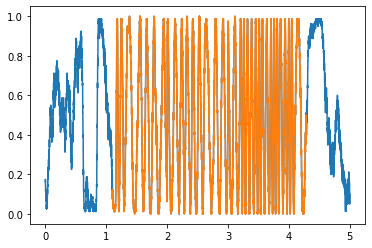

In [167]:
intervals = [
    [8100, 19700],
    [11400, 16800],
    [20200, 32600],
    [15200, 22300],
    [12700, 19000],
    [9200, 19600],
    [7800, 17800],
    [21100, 54000],
    [10000, 23000],
    [33000, 84000],
    # [8500, 23300],
    # [0,-1],
    [36000, 140000],
    [33500, 64000],
]
i = 10
data = load_data(i)
normalize_data(data)

start = intervals[i][0]
end = intervals[i][1]

plt.plot(data[:,0], data[:,1])
plt.plot(data[start:end,0], data[start:end,1])

57
60


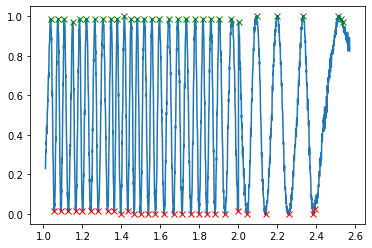

In [162]:
high_peaks = find_peaks(data[start:end,1], height=0.95, distance=400)[0]
low_peaks = find_peaks(-data[start:end,1], height=-0.05, distance=400)[0]
plt.plot(data[start:end,0], data[start:end,1])
plt.plot(data[low_peaks+start,0], data[low_peaks+start,1], 'rx')
plt.plot(data[high_peaks+start,0], data[high_peaks+start,1], 'gx')
print(count_peaks_and_troughs(data[start:end], 0.05, 0.95))
print(len(high_peaks)+len(low_peaks))

In [168]:
phases = []
for i in range(12):
    signal = load_data(i)
    start = intervals[i][0]
    end = intervals[i][1]
    signal = normalize_data(signal[start:end])

    # high_peaks = find_peaks(signal[:,1], height=0.97, distance=400)[0]
    # low_peaks = find_peaks(-signal[:,1], height=-0.05, distance=400)[0]
    p = count_peaks_and_troughs(signal, 0.05, 0.95)*np.pi
    print(p)
    phases.append(p)

37.69911184307752
37.69911184307752
59.690260418206066
62.83185307179586
62.83185307179586
94.24777960769379
87.96459430051421
128.8052987971815
113.09733552923255
179.0707812546182
210.48670779051614
204.20352248333654


In [175]:
def linear(x, *args):
    A,B=args
    return A*x+B

[138.78042876  -6.20674753] [0.68348611 0.62588139]


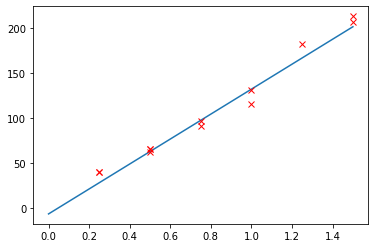

In [180]:
popt,pcov = curve_fit(linear, pressures[:len(phases)], np.array(phases), p0=(135, 0), absolute_sigma=True)
print(popt, np.sqrt(np.diag(pcov)))
ps = np.linspace(0, 1.5, 100)
plt.plot(ps, linear(ps,*popt))
plt.plot(pressures[:len(phases)], np.array(phases)+np.pi, 'rx')

In [6]:
def adv_sine(x, *args):
    a,b,c,d,e,f = args
    return np.sin(c+d*x + e*x*x + f*x*x*x)*a + b
def find_phase(t1, t2, *args):
    a,b,c,d,e,f = args
    return abs(d*t2 + e*t2*t2 + f*t2*t2*t2  - (d*t1 + e*t1*t1 + f*t1*t1*t1))

[ 4.77579953e-01  5.24204399e-01  3.14159265e+00  2.41262603e+02
 -1.07520651e+03  1.87899391e+03]
10.757015230975696
[ 3.50000000e-01  5.84782127e-01  3.14159260e+00  6.08759861e+02
 -2.00000000e+03  1.92496675e+03]
27.862802370359958
52.9955435990783


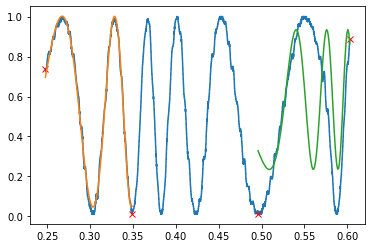

In [22]:
subdiv = np.array([0])
peaks = find_peaks(-data[start:end,1], height=-0.05, distance=300)[0]
subdiv = np.append(subdiv,[peaks[1], peaks[-2]])
subdiv = np.append(subdiv, end-start)
subdiv += start
plt.plot(data[start:end,0], data[start:end,1])
plt.plot(data[subdiv,0], data[subdiv,1], 'rx')

total_phase = 0
cs = []
bounds = ((0.35, 0.35, -np.pi, -1000, -2000, -2000), (0.65, 0.65, np.pi, 1000, 2000, 2000))
for j in (1, len(subdiv)-1):
    sub_data = data[subdiv[j-1]:subdiv[j]]
    
    popt, pcov = curve_fit(adv_sine, sub_data[:,0], sub_data[:,1], p0=[0.5, 0.5, 0., 100., 1., 0.], maxfev=30000, bounds=bounds)
    cs.append(popt[2])
    print(popt)
    xs = np.linspace(sub_data[0,0], sub_data[-1,0], 100)
    plt.plot(xs, adv_sine(xs, *popt))
    total_phase += find_phase(sub_data[0,0],sub_data[-1,0],*popt)
    print(total_phase)
print(total_phase + 2*np.pi*(len(peaks)-2))

41.970492744181634


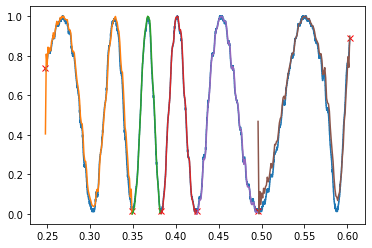

In [16]:
#Upper estimate
n_samples = 100
subdiv = np.array([0])
subdiv = np.append(subdiv,find_peaks(-data[start:end,1], height=-0.05, distance=300)[0][1:-1])
subdiv = np.append(subdiv, end-start)
subdiv += start
plt.plot(data[start:end,0], data[start:end,1])
plt.plot(data[subdiv,0], data[subdiv,1], 'rx')

total_phase = 0
for j in range(1,len(subdiv)):
    sub_data = data[subdiv[j-1]:subdiv[j]]
    sub_resample = signal.resample(sub_data[:,1], n_samples)
    sub_resample -= np.min(sub_resample)
    sub_resample /= np.max(sub_resample)
    plt.plot(np.linspace(sub_data[0,0], sub_data[-1,0], n_samples), sub_resample)
    total_phase += np.cumsum(np.abs(np.diff(np.arccos(2*sub_resample-1))))[-1]
print(total_phase)

37.69911184307752

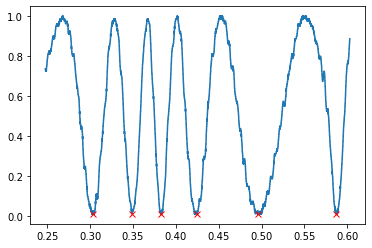

In [17]:
# xs = np.linspace(data[start,0], data[end,0], 10000)
# plt.plot(xs, adv_sine(xs, *popt))

#Lower estimate
zeros = find_peaks(-data[start:end,1], height=-0.05, distance=300)[0]
plt.plot(data[start:end,0], data[start:end,1])
plt.plot(data[zeros+start,0], data[zeros+start,1], 'rx')
len(zeros)*2*np.pi

In [274]:
avg = (total_phase + len(zeros)*2*np.pi)/2
print(avg)

38.85562481987076


In [216]:
detected = np.append(detected, avg)

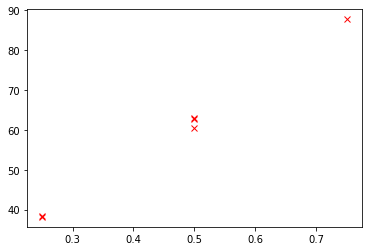

In [217]:
plt.plot(pressures[:len(detected)], detected, 'rx')

800
81.29215914030682


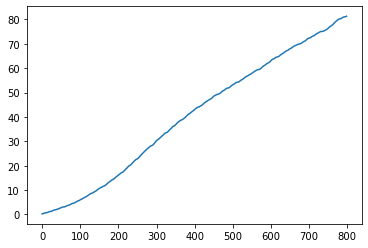

In [214]:
n_samples = 800
print(n_samples)
resmpl = signal.resample(data[start:end,1], n_samples)
resmpl -= np.min(resmpl)
resmpl /= np.max(resmpl)
plt.plot(np.cumsum(np.abs(np.diff(np.arccos(2*resmpl-1)))))
print(np.cumsum(np.abs(np.diff(np.arccos(2*resmpl-1))))[-1])

In [257]:
def adv_sine(x, *args):
    a,b,c,d,e,f = args
    return np.sin(c+d*x+e*x*x+f*x*x*x)*(a) + b
start = 21000
end = 51000
popt, pcov = curve_fit(adv_sine, data[start:end,0], data[start:end,1], p0=[1, 0.5, 0, 100, 20, -10], maxfev=3000)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 3000.

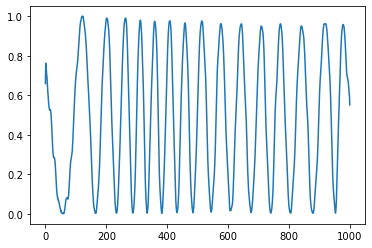

In [33]:
plt.plot(resmpl)


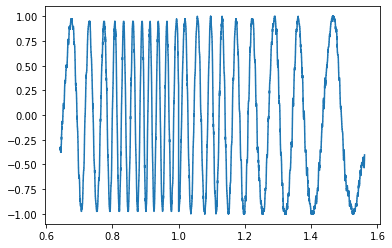

In [230]:
start = 21000
end = 51000
plt.plot(data[start:end,0], 2*data[start:end,1]-1)

In [278]:
np.cumsum(np.abs(np.diff(np.arccos(2*resmpl-1))))[-1]

102.46412269382797